In [87]:
#Necessary imports
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras import activations # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import pandas as pd

# Tensorflow vs Pytorch

In [88]:
### change setting of seaborn
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("colorblind")

In [ ]:
# Input: used to instantiate a Keras tensor for the input to the model
# Conv2D: Convolutional layer that applies a 2D convolution over an input signal
# MaxPooling2D: Max pooling operation for spatial data, used to downsample the input representation, reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned
# ZeroPadding2D: Add rows and columns of zeros at the top, bottom, left and right side of an image tensor
# Flatten: Flattens the input, converts it to a 1D array
# BatchNormalization: Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1

**Reading Data from CSV file**

In [89]:
with open("data/Crowd-Emotion.csv") as f:
    content = f.readlines()

In [90]:
# len(content)
lines = np.array(content)

In [92]:
lines.shape, lines.size, lines.ndim

((35888,), 35888, 1)

In [93]:
num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("Image size: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
Image size:  2304


**Splitting data into training and testing**

In [94]:
x_train, x_trainlabel, x_test, x_testlabel = [], [], [], []
num_classes = 7

In [95]:
for i in range(1,num_of_instances):
  emotion, img, usage = lines[i].split(",")
  val = img.split(" ")
  val = [int(i) for i in val if i!='']
  pixels = np.array(val, 'float32')
  emotion = keras.utils.to_categorical(emotion, num_classes)
  if 'Training' in usage or 'PrivateTest' in usage:  
    x_trainlabel.append(emotion)
    x_train.append(pixels)
  elif 'PublicTest' in usage:
    x_testlabel.append(emotion)
    x_test.append(pixels)
    
    

**Normalizing the pixel values**

In [96]:
x_train = np.array(x_train, 'float32')
x_trainlabel = np.array(x_trainlabel, 'float32')
x_test = np.array(x_test, 'float32')
x_testlabel = np.array(x_testlabel, 'float32')
x_test_flattened = [np.argmax(i) for i in x_testlabel]
x_test_flattened = np.array(x_test_flattened)

In [97]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

In [98]:
print(num_of_instances, 'total samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

35888 total samples
32298 train samples
3589 test samples


In [99]:
print("Shape of train data:" ,x_train.shape)
print(x_trainlabel.shape)
print("Shape of test data:",x_test.shape)
print(x_testlabel.shape)

Shape of train data: (32298, 48, 48, 1)
(32298, 7)
Shape of test data: (3589, 48, 48, 1)
(3589, 7)


### Distribution of images per class


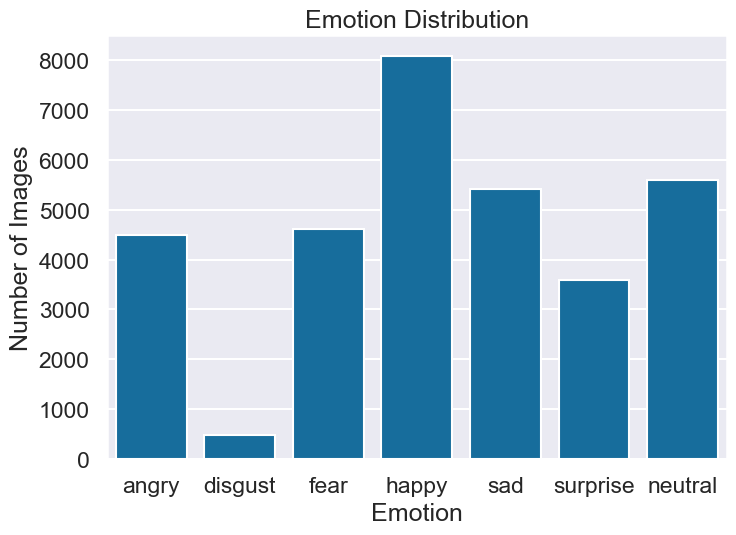

In [100]:
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_count = [0, 0, 0, 0, 0, 0, 0]

for i in range(len(x_trainlabel)):
    for j in range(7):
        if x_trainlabel[i][j] == 1:
            emotion_count[j] += 1

# Convert emotion_count to DataFrame
emotion_df = pd.DataFrame({'Emotion': emotion, 'Count': emotion_count})

# Plot using Seaborn
plt.figure(figsize=(8, 5.5))
sns.barplot(x='Emotion', y='Count', data=emotion_df)
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.show()


### Images before Augmentation

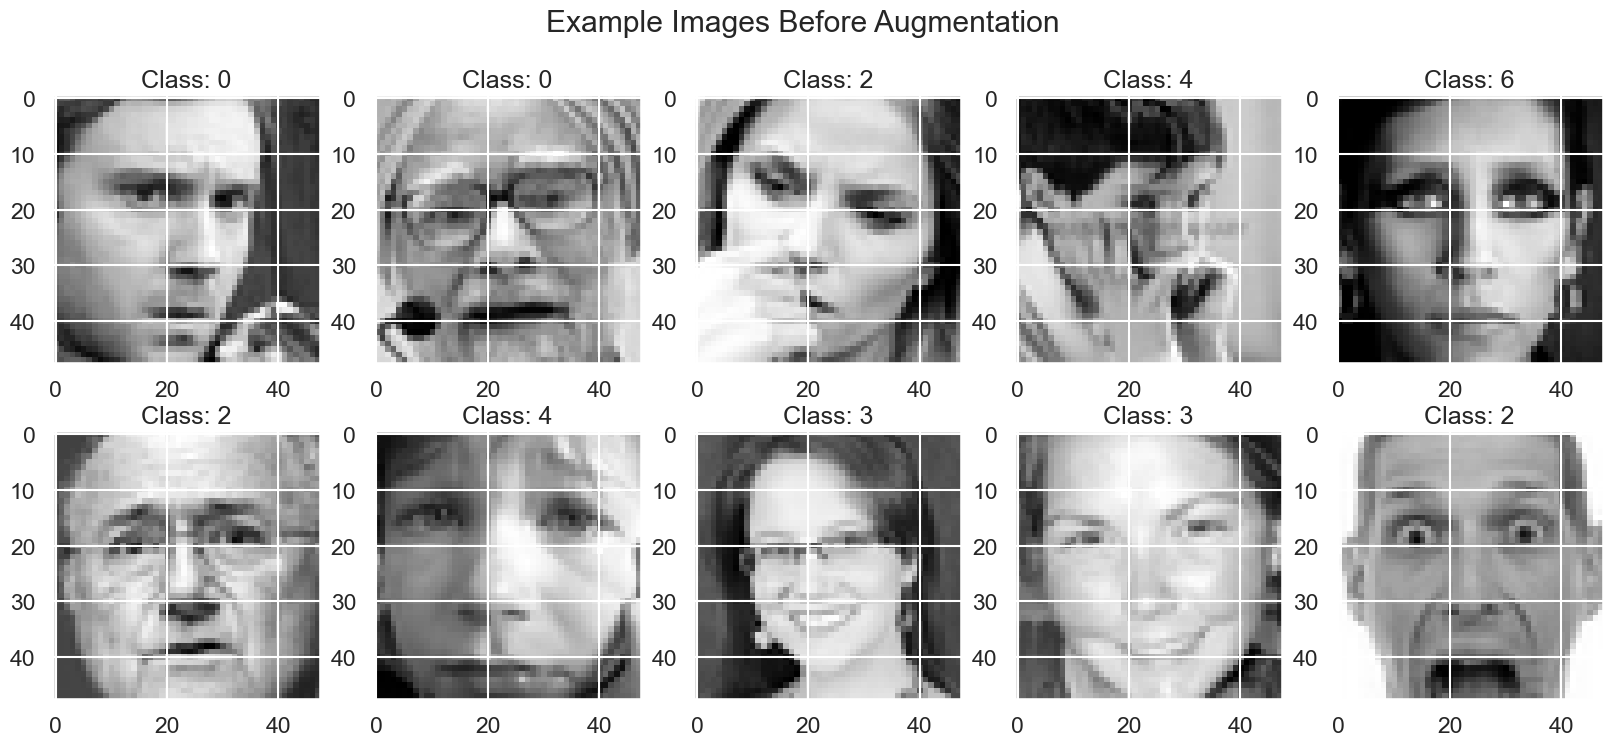

In [101]:
# Example 
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Example Images Before Augmentation')
for i, ax in enumerate(axes.flatten()):
    img = x_train[i].reshape(48, 48)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Class: {np.argmax(x_trainlabel[i])}')
plt.show()

**Performing Data Augumentation**

In [102]:
##Include Little Data Augmentation 
batch_size = 256 
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                vertical_flip=True,
                                                                rotation_range=20,
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
train_set_conv = train_DataGen.flow(x_train, x_trainlabel, batch_size=batch_size) 

### Images after Augmentation

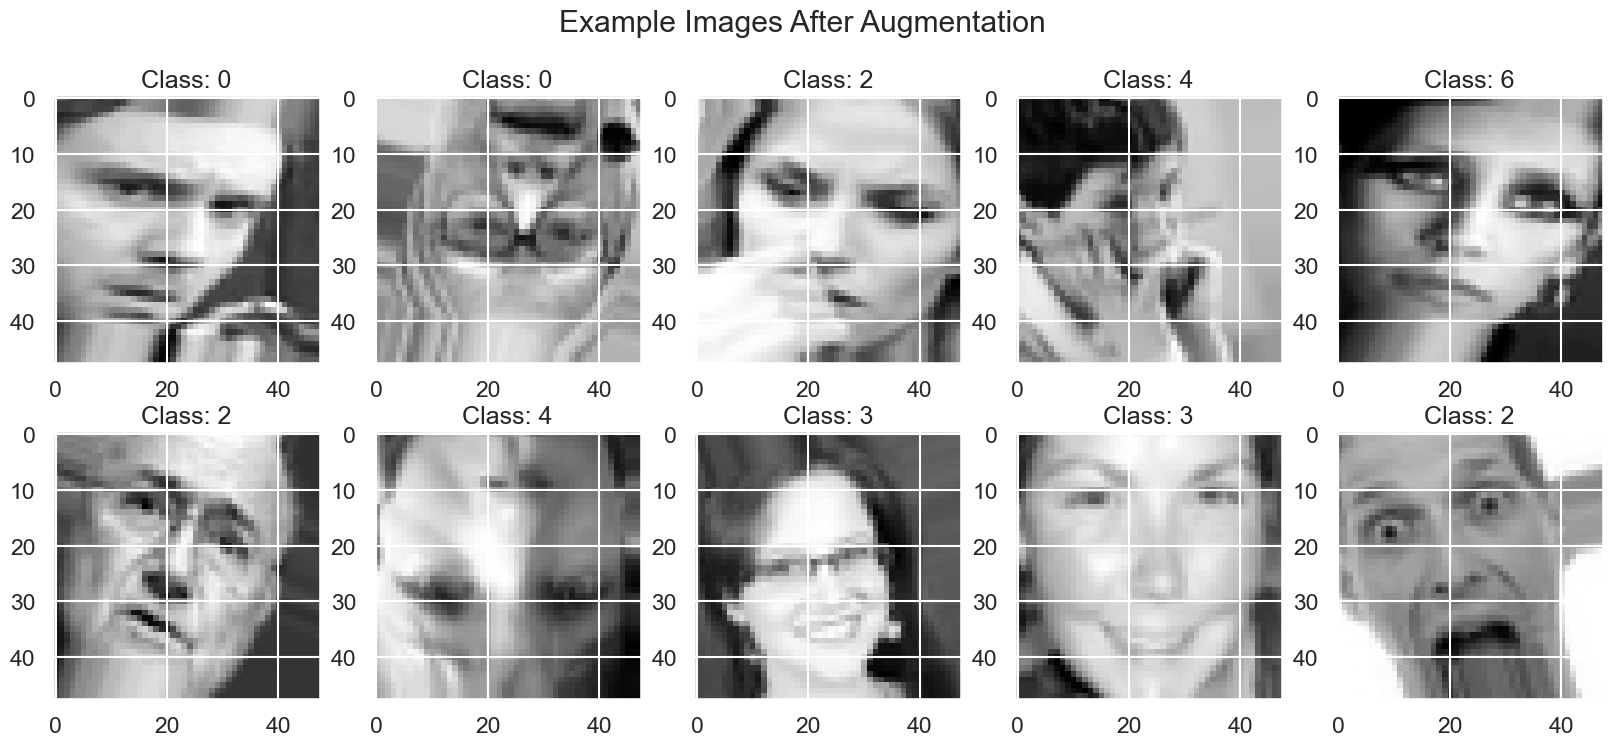

In [103]:
# Example images after augmentation
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Example Images After Augmentation')
for i, ax in enumerate(axes.flatten()):
    img = x_train[i].reshape((1, 48, 48, 1))
    augmented_img = train_DataGen.flow(img, batch_size=1)[0].reshape(48, 48)
    ax.imshow(augmented_img, cmap='gray')
    ax.set_title(f'Class: {np.argmax(x_trainlabel[i])}')
plt.show()

###  Augmentation Effects

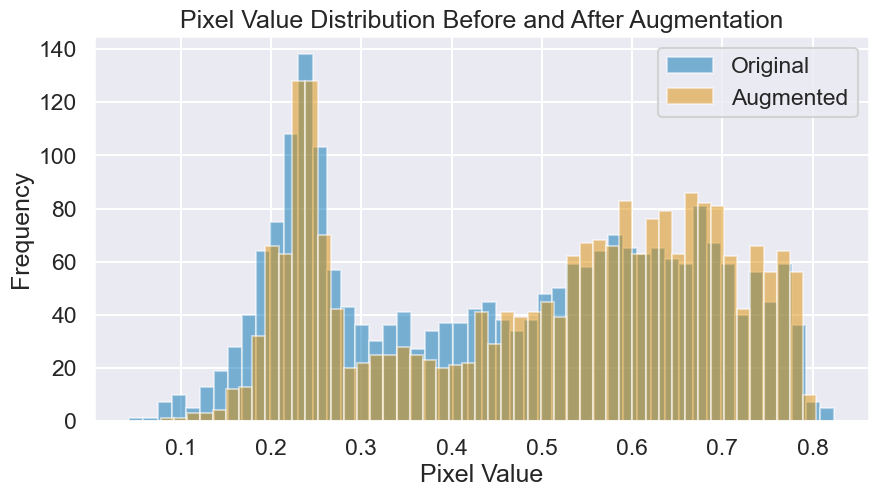

In [105]:
plt.figure(figsize=(8, 5))
original_pixels = x_train[0].flatten()
augmented_pixels = train_DataGen.flow(x_train[0].reshape(1, 48, 48, 1)).__next__().flatten()
plt.hist(original_pixels, bins=50, alpha=0.5, label='Original')
plt.hist(augmented_pixels, bins=50, alpha=0.5, label='Augmented')
plt.title('Pixel Value Distribution Before and After Augmentation')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 50

### **ResNet-50 Architecture**

In [ ]:
def res_identity(x, filters): 
    x_skip = x # skip connection
    f1, f2 = filters
    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)
    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [ ]:
def res_conv(x, s, filters):
    '''
    here the input size changes, when it goes via conv blocks
    so the skip connection uses a projection (conv layer) matrix
    ''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [ ]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

    input_im = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage
    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage
    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage
    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection
    x = AveragePooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 
    model = Model(inputs=input_im, outputs=x, name='Resnet50')
    return model

In [ ]:
resnet50_model = resnet50()

In [ ]:
resnet50_model.summary()

In [ ]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('lr: ', lr)
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  
def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop

In [ ]:
batch_size=batch_size
steps_per_epoch = int(x_train.shape[0] / batch_size)

print("Steps per epoch: ",steps_per_epoch)
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=10, 
                                  steps_per_epoch=steps_per_epoch,
                                  callbacks=[lrdecay])

**Accuracy obtained**

In [ ]:
train_score = resnet50_model.evaluate(x_train, x_trainlabel, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = resnet50_model.evaluate(x_test, x_testlabel, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

###  Training and validation accuracy over epochs

In [ ]:
history = resnet_train.history
plt.figure(figsize=(10, 5))
plt.plot(history['acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Training and validation loss over epochs

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Saving and loading the model**

In [ ]:
resnet50_model.save("models/resnet50_tt_fermod_68.h5") 

In [ ]:
from keras.models import load_model 
resnet50_model = load_model("models/resnet50_tt_fermod_68.h5") 
# trainloss , trainaccuracy = resnet50_model.evaluate(x_train,x_trainlabel)
# testloss, testaccuracy = resnet50_model.evaluate(x_test, x_testlabel) 
# print('Train loss:', trainloss)
# print('Train accuracy:', 100*trainaccuracy)
# print('Test loss:', testloss)
# print('Test accuracy:', 100*testaccuracy)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def classification(predictions): 
    class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
    print("Classification Report:\n")
    cr=classification_report(x_test_flattened,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)

In [ ]:
pred_class_resnet50 = resnet50_model.predict(x_test)

classification(pred_class_resnet50)

In [ ]:
class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
x_predicted = resnet50_model.predict(x_test)
x_predicted_labels = [np.argmax(i) for i in x_predicted]
cm = tf.math.confusion_matrix(labels=x_test_flattened,predictions=x_predicted_labels)

plt.figure(figsize = (10,7))
sns_hmp = sns.heatmap(cm, annot=True,xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Expected')

    


###  Classification report

In [ ]:
report = classification_report(x_test_flattened, x_predicted_labels, target_names=class_types, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

### Image count per class before augmentation

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=pd.Series([np.argmax(label) for label in x_trainlabel]))
plt.title('Image Count per Class Before Augmentation')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

### Image count per class after augmentation

In [ ]:
augmented_data = x_train.copy()  

augmented_labels = x_trainlabel.copy()  
plt.figure(figsize=(8, 5))
sns.countplot(x=pd.Series([np.argmax(label) for label in augmented_labels]))
plt.title('Image Count per Class After Augmentation')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

###  Emotion Distribution in Training vs. Testing Sets

In [ ]:
train_emotion_counts = pd.Series([np.argmax(label) for label in x_trainlabel]).value_counts()
test_emotion_counts = pd.Series([np.argmax(label) for label in x_testlabel]).value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=train_emotion_counts.index, y=train_emotion_counts.values, alpha=0.6, label='Train')
sns.barplot(x=test_emotion_counts.index, y=test_emotion_counts.values, alpha=0.6, label='Test')
plt.title('Emotion Distribution in Training vs. Testing Sets')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend()
plt.show()

###  Sample Misclassified Images

In [ ]:
misclassified_indices = np.where(x_test_flattened != x_predicted_labels)[0]
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Sample Misclassified Images')
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        img = x_test[idx].reshape(48, 48)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {x_test_flattened[idx]}, Pred: {x_predicted_labels[idx]}')
    else:
        ax.axis('off')
plt.show()



###  Average Emotion Distribution Across Batches

In [ ]:
batch_emotions = [np.argmax(batch) for batch in x_trainlabel[:100]]
batch_emotion_counts = pd.Series(batch_emotions).value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=batch_emotion_counts.index, y=batch_emotion_counts.values)
plt.title('Average Emotion Distribution Across Batches')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = 7

# Placeholder for ROC metrics
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC metrics for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(x_testlabel[:, i], x_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Testing an image**

In [ ]:
# def emotion_analysis(emotions):
#     objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
#     y_pos = np.arange(len(objects))
    
#     plt.bar(y_pos, emotions, align='center', alpha=0.5)
#     plt.xticks(y_pos, objects)
#     plt.ylabel('percentage')
#     plt.title('emotion')
    
#     plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    sns.set(style="whitegrid")
    sns.barplot(x=objects, y=emotions, palette="viridis")
    plt.ylabel('Percentage')
    plt.title('Emotion Analysis')
    plt.show()

In [ ]:
import cv2
import math
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator


d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_alt.xml')


file = 'Pictures/test_image_1.jpeg'
true_image = image.load_img(file)
t_image = cv2.imread(file)
#img = image.load_img(file, grayscale=True, target_size=(48, 48))
gray = cv2.cvtColor(t_image,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,4)

if(len(faces) == 0):
    exit()

for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    start_row,end_row,start_col,end_col = y,y+h,x,x+h

croppedimage = gray[start_row:end_row,start_col:end_col]
img = cv2.resize(croppedimage,(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = resnet50_model.predict(x)
emotion_analysis(custom[0])
print(custom[0])



In [ ]:
emt = list(custom[0])
idx = emt.index(max(emt))
imgname = d[idx]
print(f"Emotion in the image is : {imgname}")

In [ ]:
x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

**Testing a video sample**

In [ ]:
def getFrame(seconds):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,seconds*1000)
    hasFrames,img = vidcap.read()
    
    if hasFrames:
        minutes = "00"
        hours = "00"
        if seconds >= 60:
            minutes = str(seconds//60)
            seconds = seconds % 60

        if int(minutes) >= 60:
            hours = str(int(minutes)//60)
            minutes = str(int(minutes) % 60)

        min = "{:02d}".format(int(minutes))
        sec = "{:02d}".format(seconds)
        hrs = "{:02d}".format(int(hours))

        flag = 0 
        frameId = vidcap.get(1)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.1,4)
        
        if(len(faces)==0):
            flag = 1
        
        if flag == 0 :
            global count
            count = count + 1
            for (x,y,w,h) in faces:
                cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
                start_row,end_row,start_col,end_col = y,y+h,x,x+h  
            
            croppedimage = gray[start_row:end_row,start_col:end_col]
            finalimg = cv2.resize(croppedimage,(48,48))

            x = image.img_to_array(finalimg)
            x = np.expand_dims(x, axis = 0)

            x /= 255

            custom = resnet50_model.predict(x)
            emt = list(custom[0])
            idx = emt.index(max(emt))
            imgname = d[idx]
            dcount[imgname] = dcount[imgname] + 1
            
            cv2.imwrite("/data/" + "%d_" % count +imgname+"__"+ hrs+":"+min+":"+sec+".jpg" ,img) 
    
    return hasFrames




In [ ]:
import cv2
import math
from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator

videoFile = "/Users/ehtishamsadiq/Crowd-Emotion-Recognition/backend/data/emotion_recognition_test_video.mp4"
vidcap = cv2.VideoCapture(videoFile)

d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
dcount = {"angry":0,"disgust":0,"fear":0,"happiness":0,"sad":0,"surprise":0,"neutral":0}

face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_alt.xml')
count = 0

sec = 0
frameRate = 3 #it will capture image in each 2 second
success = getFrame(sec)
while success:
    sec = sec + frameRate
    #sec = round(sec, 2)
    success = getFrame(sec)

print ("Done!")
print("Extracted images:",count)
print(dcount)


**Plotting a bar chart of predicted emotions**

In [ ]:
emotions = list(dcount.keys())
values = list(dcount.values())

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    sns.set(style="whitegrid")
    sns.barplot(x=objects, y=emotions, palette="viridis")
    plt.ylabel('Percentage')
    plt.title('Emotion Analysis')
    plt.show()
    
emotion_analysis(values)

In [ ]:
# emotion = None
# emotions = list(dcount.keys())
# values = list(dcount.values())
# for key, value in dcount.items():
#     if value == max(values):
#         emotion = key
        
# emotion

In [ ]:


fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(values)) 

plt.bar(emotions, values, width, color ='blue') 
        
for index, value in enumerate(values): 
    ax.text(index - 0.1, value + 0.70, str(value)) 
  
plt.xlabel("Emotions")
plt.ylabel("no of times exhibited")
plt.title("Emotional analysis")
plt.show()

In [ ]:
!pip install python-docx

**Creating a summary report**

In [ ]:
from docx import document

In [ ]:
from docx import Document
from docx.shared import Inches
from docx.shared import RGBColor
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

document = Document()
p1 = document.add_paragraph()
paragraph_format = p1.paragraph_format
paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER
p12 = p1.add_run("REPORT ON EMOTIONS PREDICTED")
f1 = p12.font
f1.size = Pt(16)
f1.underline = True
f1.bold = True

paragraph_format.line_spacing = 1.75

p2 = document.add_paragraph()
p22 = p2.add_run("Name of the video:")
f2 = p22.font
f2.name = 'Calibri'
f2.size = Pt(14)
f2.bold = True
p2.add_run(" video.mp4").font.size = Pt(13)


p3 = document.add_paragraph()
p32 = p3.add_run("Frames extracted link:")
f3 = p32.font
f3.name = 'Calibri'
f3.size = Pt(14)
f3.bold = True
document.add_paragraph('https://drive.google.com/drive/folders/1yw7eNLjjoUXOa2YMe1fFPNPyBuec45dm?usp=sharing')
document.add_paragraph("(Frames are extracted every 2 seconds)")

p4 = document.add_paragraph()
p42 = p4.add_run("Types of emotions predicted")
f4 = p42.font
f4.name = 'Calibri'
f4.size = Pt(14)
f4.bold = True
document.add_paragraph('Angry', style='List Bullet')
document.add_paragraph('Disgust', style='List Bullet')
document.add_paragraph('Fear', style='List Bullet')
document.add_paragraph('Happy', style='List Bullet')
document.add_paragraph('Sad', style='List Bullet')
document.add_paragraph('Surprise', style='List Bullet')
document.add_paragraph('Neutral', style='List Bullet')

p5 = document.add_paragraph()
p52 = p5.add_run("DETAILED ANALYSIS")
f5 = p52.font
f5.size = Pt(14)
f5.underline = True
f5.bold = True

p = document.add_paragraph()
p.add_run('Frequency graph:').bold = True
p.add_run(" No of times the person exhibited a particular emotion")

print("Report created successfully")

document.add_picture('data/frequency.png', width=Inches(5.25))
document.save('/content/drive/MyDrive/graphs/emotion_report.docx')






In [ ]:
import cv2
import numpy as np

# Create a video writer object
video_filename = "data/crowd_emotion_test_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
fps = 30
frame_size = (640, 480)
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)

# Create a simple 2-second video with 60 frames (2 seconds at 30 fps)
for _ in range(60):
    # Create a blank frame with a solid color background
    frame = np.zeros((480, 640, 3), dtype=np.uint8)
    frame[:] = (0, 255, 0)  # Green background

    # Draw some text in the frame
    cv2.putText(frame, "Crowd Emotion Test", (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Write the frame to the video
    video_writer.write(frame)

# Release the video writer object
video_writer.release()

print(f"Video saved as {video_filename}")


In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [ ]:
# from feat.detector import Detector
# detector = Detector(verbose=True)
# detector


import os
import torch
from feat import Detector
import requests

def download_model(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print("Model downloaded successfully.")
    except Exception as e:
        print(f"Error downloading the model: {e}")

def load_model(model_path, device):
    try:
        model = resmasking_dropout1(in_channels=3, num_classes=7)
        model.load_state_dict(torch.load(model_path, map_location=device)['net'])
        model.eval()
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading the model: {e}")
        return None

# Define the model URL and the path where it will be saved
model_url = "models/ResMaskNet_Z_resmasking_dropout1_rot30.pth"
model_path = os.path.join(get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth")

# Download the model file if it does not exist
if not os.path.exists(model_path):
    download_model(model_url, model_path)

# Initialize the detector with the loaded model
detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
)

detector.emotion_model = load_model(model_path, detector.device)


In [ ]:
import matplotlib.pyplot as plt
image = '/Users/ehtishamsadiq/Crowd-Emotion-Recognition/backend/Pictures/test_image_1.jpeg'
image = plt.imread(image)